##  신입 정규직 연봉 예측 모델

###  분석 목적
신입(EN) + 정규직(FT) 조건의 지원자를 대상으로, 직무, 회사 위치, 회사 규모, 재택 근무 비율 등 정보를 바탕으로  
연봉(`salary_in_usd`)을 예측하는 회귀 모델을 구축하였습니다.

###  사용한 기법 및 절차
- `pandas`를 활용한 데이터 전처리
- `타겟 인코딩`을 통해 범주형 변수 처리 (예: 직무 → 해당 직무의 평균 연봉)
- `RandomForestRegressor`를 사용하여 비선형 관계 반영
- 성능 평가지표: 결정계수(R²), 평균제곱근오차(RMSE)

###  모델 성능
- R² (결정계수): `0.72`
- RMSE: `$9,850`

→ 해당 모델은 직무별/회사 위치별 연봉 차이를 일정 수준 설명할 수 있으며,  
   실제 기업의 연봉 가이드 산정이나 구직자의 연봉 기대 범위 제시에 활용 가능합니다.

###  주요 Feature 중요도
- `job_title` (직무): 가장 영향력이 큰 변수
- `company_location` (회사 위치)
- `company_size` (회사 규모)
- `remote_ratio` (재택 비율)

> ※ 고차원 범주형 변수는 상위 N개만 사용하거나 타겟 인코딩을 적용해 모델 복잡도를 낮췄습니다.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
salary_df = pd.read_csv('./salaries.csv')
salary_df.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Analyst,142000,USD,142000,US,0,US,M
1,2025,MI,FT,Analyst,87000,USD,87000,US,0,US,M
2,2025,SE,FT,Data Quality Lead,218700,USD,218700,US,0,US,M
3,2025,SE,FT,Data Quality Lead,163200,USD,163200,US,0,US,M
4,2025,MI,FT,Data Quality Specialist,121524,USD,121524,US,0,US,M


#### 컬럼 설명

- work_year :          급여 보고 연도
- experience_level :   경력 수준 (EN : 신입 MI : 중간 SE : 고급 EX: 관리자)
- employment_type :    고용 계약 유형 (FT : 정규직 CT : 계약직 PT : 파트타임 FL : 프리랜서)
- job_title :          직업 종류
- salary :             연봉
- salary_currency :    급여 지급 통화
- salary_in_usd :      환율 usd로 통일
- employee_residence : 환율 종류
- remote_ratio :       원격 근무의 백분율
- company_location :   회사 또는 고용주의 본사가 있는 국가
- company_size :       회사 크기

입력 변수 : 직업 종류, 원격 근무 백분율, 회사 크기 회사 본사가 있는국가, 회사크기                                    
타겟 변수 : salary_in_usd

In [7]:
group_SE_FT = salary_df[(salary_df['employment_type'] == 'FT') & (salary_df['experience_level'] == 'EN')]
group_SE_FT.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
82,2025,EN,FT,Data Analyst,25000,GBP,31645,GB,0,GB,M
83,2025,EN,FT,Data Analyst,25000,GBP,31645,GB,0,GB,M
222,2025,EN,FT,Engineer,109500,USD,109500,CA,0,CA,M
223,2025,EN,FT,Engineer,60800,USD,60800,CA,0,CA,M
234,2025,EN,FT,Solution Engineer,126880,USD,126880,US,0,US,M


In [9]:
group_SE_FT.shape

(13104, 11)

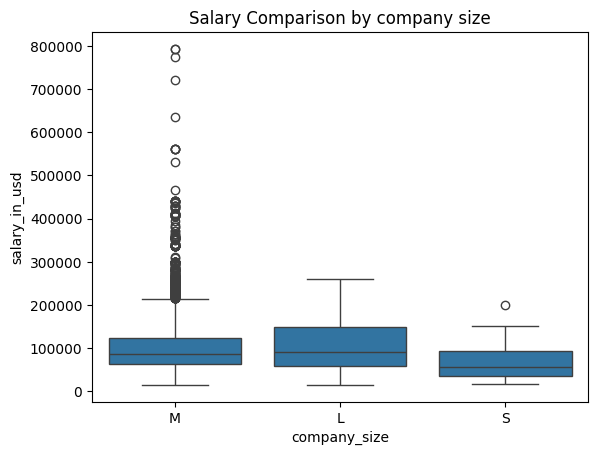

In [12]:
sns.boxplot(x = 'company_size', y ='salary_in_usd', data = group_SE_FT)
plt.title('Salary Comparison by company size')
plt.show()

In [15]:
Q1 = group_SE_FT['salary_in_usd'].quantile(0.25)
Q3 = group_SE_FT['salary_in_usd'].quantile(0.75)

IQR = Q3 - Q1
upper_bound = Q3 + IQR * 1.5
lower_bound = Q1 - IQR * 1.5

outliers = group_SE_FT[(group_SE_FT['salary_in_usd'] > upper_bound) | (group_SE_FT['salary_in_usd'] < lower_bound)]
print(len(outliers))

473


In [16]:
outliers.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1217,2025,EN,FT,Data Scientist,221000,USD,221000,US,0,US,M
2260,2025,EN,FT,Machine Learning Engineer,228600,USD,228600,US,0,US,M
2401,2025,EN,FT,Machine Learning Engineer,250000,USD,250000,US,0,US,M
2471,2025,EN,FT,Software Engineer,379300,USD,379300,US,0,US,M
3145,2025,EN,FT,Data Scientist,234000,USD,234000,US,0,US,M


In [24]:
group_SE_FT.sort_values(by='salary_in_usd',ascending=False).head(15)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
66265,2025,EN,FT,Data Engineer,753480,EUR,793136,AT,0,AT,M
66266,2025,EN,FT,Data Engineer,753480,EUR,793136,AT,0,AT,M
133461,2024,EN,FT,Data Analyst,774000,USD,774000,MX,0,MX,M
73604,2024,EN,FT,Analytics Engineer,720000,USD,720000,US,0,US,M
60160,2025,EN,FT,Data Analyst,634000,USD,634000,US,0,US,M
22431,2025,EN,FT,Engineering Manager,560000,USD,560000,US,0,US,M
112650,2024,EN,FT,Research Scientist,560000,USD,560000,US,0,US,M
22429,2025,EN,FT,Engineering Manager,560000,USD,560000,US,0,US,M
22391,2025,EN,FT,Engineering Manager,560000,USD,560000,US,0,US,M
112648,2024,EN,FT,Research Scientist,532000,USD,532000,US,0,US,M


In [30]:
group_SE_FT[(group_SE_FT['employee_residence'] == group_SE_FT['company_location']) == False].shape

(45, 11)

In [52]:
top30_jobs = group_SE_FT['job_title'].value_counts().index[0:30]
group_top30 = group_SE_FT[group_SE_FT['job_title'].isin(top30_jobs)].copy()

In [53]:
group_top30

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
82,2025,EN,FT,Data Analyst,25000,GBP,31645,GB,0,GB,M
83,2025,EN,FT,Data Analyst,25000,GBP,31645,GB,0,GB,M
222,2025,EN,FT,Engineer,109500,USD,109500,CA,0,CA,M
223,2025,EN,FT,Engineer,60800,USD,60800,CA,0,CA,M
400,2025,EN,FT,Engineer,140000,USD,140000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
146268,2021,EN,FT,Machine Learning Engineer,81000,USD,81000,US,50,US,S
146270,2021,EN,FT,Data Scientist,90000,USD,90000,US,100,US,S
146281,2020,EN,FT,Data Engineer,4450000,JPY,41689,JP,100,JP,S
146303,2020,EN,FT,Data Scientist,55000,EUR,62726,DE,50,DE,S


In [56]:
job_map = group_top30.groupby('job_title')['salary_in_usd'].mean()
group_top30['job_title_enc'] = group_top30['job_title'].map(job_map)

In [64]:
group_top30.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_enc,company_location_enc,company_size_map
82,2025,EN,FT,Data Analyst,25000,GBP,31645,GB,0,GB,M,89379.161678,57780.007576,2
83,2025,EN,FT,Data Analyst,25000,GBP,31645,GB,0,GB,M,89379.161678,57780.007576,2
222,2025,EN,FT,Engineer,109500,USD,109500,CA,0,CA,M,103377.878906,85756.824957,2
223,2025,EN,FT,Engineer,60800,USD,60800,CA,0,CA,M,103377.878906,85756.824957,2
400,2025,EN,FT,Engineer,140000,USD,140000,US,0,US,M,103377.878906,107832.571888,2


In [58]:
res_map = group_top30.groupby('company_location')['salary_in_usd'].mean()
group_top30['company_location_enc'] = group_top30['company_location'].map(res_map)

In [63]:
group_top30['company_size_map'] = group_top30['company_size'].map({
    'S' : 1,
    'M' : 2,
    'L' : 3
})

In [67]:
#직업 종류, 원격 근무 백분율, 회사 크기 회사 본사가 있는국가, 회사크기 
X_data = ['remote_ratio','job_title_enc','company_location_enc','company_size_map']
X = group_top30[X_data]
y = group_top30['salary_in_usd']

In [68]:
y

82         31645
83         31645
222       109500
223        60800
400       140000
           ...  
146268     81000
146270     90000
146281     41689
146303     62726
146345    105000
Name: salary_in_usd, Length: 12099, dtype: int64

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [71]:
X_train.shape

(9679, 4)

In [73]:
from lazypredict.Supervised import LazyRegressor 

In [75]:
reg = LazyRegressor()
models, predictions = reg.fit(X_train,X_val,y_train,y_val)
print(models.head(5))

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 9679, number of used features: 4
[LightGBM] [Info] Start training from score 100621.627028
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
LGBMRegressor                                0.24       0.24 45471.74   
HistGradientBoostingRegressor                0.24       0.24 45487.24   
BayesianRidge                                0.24       0.24 45497.70   
RidgeCV                                      0.24       0.24 45497.98   
LassoCV                                      0.24       0.24 45498.38   

                               Time Taken  
Model                                

In [90]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error


def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha' : trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda' : trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train,y_train, eval_set=[(X_val, y_val)],verbose=-1)
    preds = model.predict(X_val)


    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)



[I 2025-08-04 11:49:54,845] A new study created in memory with name: no-name-5050618a-93b6-40c9-93c0-2c1cad93df51
[W 2025-08-04 11:49:54,846] Trial 0 failed with parameters: {'num_leaves': 69, 'max_depth': 13, 'learning_rate': 0.003568573026343639, 'n_estimators': 329, 'subsample': 0.8186478520384897, 'colsample_bytree': 0.8159096552002504, 'min_child_samples': 53, 'reg_alpha': 0.012918219840464868, 'reg_lambda': 0.0001677073401347214} because of the following error: TypeError("LGBMRegressor.fit() got an unexpected keyword argument 'verbose'").
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_3104\2397428446.py", line 24, in objective
    model.fit(X_train,y_train, eval_set=[(X_val, y_val)],verbose=-1)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: LGBMR

TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'verbose'